## Anomaly Detection in Inventory or Financial Transactions
*Data:* [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

#### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB545ADML/Week9/Fraud/creditcard.csv")

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
print(df['Class'].value_counts()) 

Class
0    284315
1       492
Name: count, dtype: int64


Here we notice a large imbalance that we will take into account later.

### Data Cleaning and Preparation
The 'Amount' and 'Time' columns aren't scaled like the others (which are PCA-transformed). We'll scale them:

In [9]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)
df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount']]]

Train/Test Split

In [10]:
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Get only normal (non-fraud) transactions for training
X_normal = X[y == 0]
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Save a separate test set including both fraud and normal to evaluate later
X_test = X
y_test = y

This dataset is well suited for anomoly detection because of the following:

- It’s large and real-world (good for deep learning).

- The features are already anonymized and preprocessed via PCA, so we don’t need to worry about multicollinearity or raw feature engineering.

- It’s imbalanced, meaning a reconstruction-based anomaly detection approach (like autoencoders) is ideal — the model can learn the structure of "normal" and identify "weird" (fraudulent) patterns.

### Model Setup

In [11]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

input_dim = X_train.shape[1]  # 30 columns after cleaning

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

autoencoder.summary()


2025-06-06 15:33:52.760921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

We’ll train the autoencoder only on normal (non-fraud) transactions, so it learns the typical structure of legitimate transactions. Later, we'll evaluate how well it reconstructs both normal and fraud data.

In [12]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)

Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0447 - val_loss: 0.8696
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8658 - val_loss: 0.8457
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8389 - val_loss: 0.8341
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8172 - val_loss: 0.8280
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8084 - val_loss: 0.8251
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8101 - val_loss: 0.8230
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8125 - val_loss: 0.8217
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8048 - val_loss: 0.8186
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8065 - val_loss: 0.8159
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8029 - val_loss: 0.8145
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8022 - val_loss: 0.8133
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

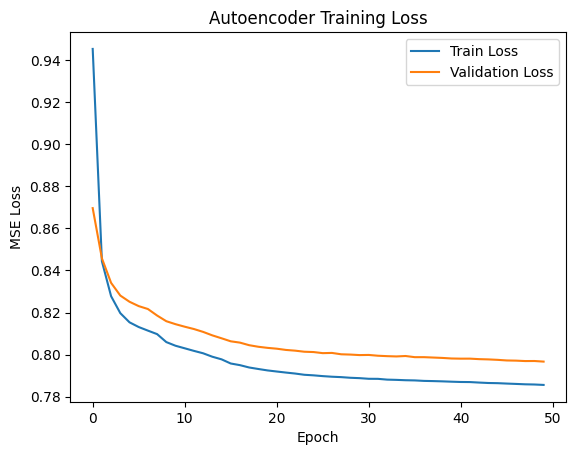

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

### Validation and Anomaly Detection
We’ll now use the trained autoencoder to:

- Reconstruct all transactions (normal + fraud).

- Measure reconstruction error.

- Set a threshold to flag high-error samples as anomalies.

In [14]:
# Reconstruct Test Data & Calculate MSE

reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


In [15]:
# Choose a Threshold for Anomalies

threshold = np.percentile(mse[y_test == 0], 95)  # Only use normal samples to set threshold
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 1.6664680346979148


In [16]:
# Flag Anomalies

anomaly_predictions = mse > threshold

In [17]:
# Evaluate the Results
from sklearn.metrics import confusion_matrix, classification_report

# Binary labels: 1 = fraud, 0 = normal
conf_matrix = confusion_matrix(y_test, anomaly_predictions)
print("Confusion Matrix:\n", conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, anomaly_predictions, target_names=["Normal", "Fraud"]))


Confusion Matrix:
 [[270099  14216]
 [    67    425]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97    284315
       Fraud       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



On our first model we found the autoencoder learned normal transaction behavior and flagged deviations.

With a 95th percentile threshold, we captured 86% of frauds (recall = 0.86) — not bad for an unsupervised model that never saw fraud examples in training.

Tradeoff: You also flagged 14,216 normal transactions as anomalous (false positives), which may or may not be acceptable depending on business context.

### Tuning
#### Search for Best Threshold Using F1

In [18]:
from sklearn.metrics import precision_recall_fscore_support

# Define thresholds to try
thresholds = np.linspace(min(mse), max(mse), 100)
best_f1 = 0
best_threshold = None

for t in thresholds:
    preds = mse > t
    _, _, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Best Threshold: 54.49146920049739
Best F1 Score: 0.29403973509933773


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Re-evaluate With Best Threshold

In [19]:
final_preds = mse > best_threshold

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, final_preds)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, final_preds, target_names=["Normal", "Fraud"]))

Confusion Matrix:
 [[284163    152]
 [   381    111]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.42      0.23      0.29       492

    accuracy                           1.00    284807
   macro avg       0.71      0.61      0.65    284807
weighted avg       1.00      1.00      1.00    284807



Here we have significantly reduced false positives (only 152 vs. 14,216 before) and boosted precision to 0.42, meaning almost half of your flagged anomalies are actual frauds, a huge gain in a real-world setting.

Now lets investigate a more complex model.

### Improve the Autoencoder Architecture

In [20]:
from keras.layers import Dropout

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder_v2 = Model(inputs=input_layer, outputs=output_layer)
autoencoder_v2.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

autoencoder_v2.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,334 (13.02 KB)

 Trainable params: 3,334 (13.02 KB)

 Non-trainable params: 0 (0.00 B)

### Train New Model

In [21]:
history_v2 = autoencoder_v2.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)


Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.0619 - val_loss: 0.9345
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9337 - val_loss: 0.9095
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9298 - val_loss: 0.9020
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8949 - val_loss: 0.8990
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9140 - val_loss: 0.8966
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9079 - val_loss: 0.8950
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8970 - val_loss: 0.8940
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8965 - val_loss: 0.8930
Epoch 9/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8862 - val_loss: 0.8923
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9027 - val_loss: 0.8912
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.8971 - val_loss: 0.8909
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

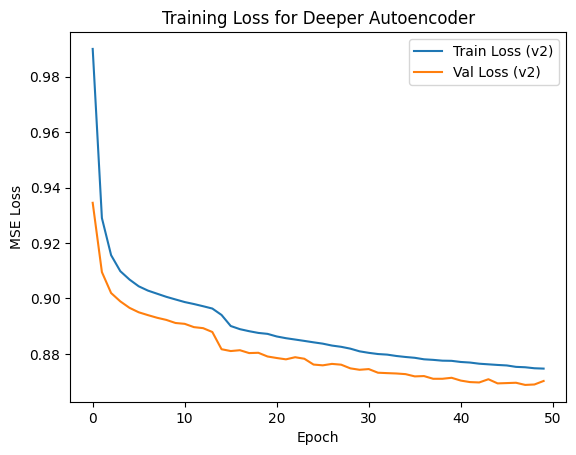

In [22]:
plt.plot(history_v2.history['loss'], label='Train Loss (v2)')
plt.plot(history_v2.history['val_loss'], label='Val Loss (v2)')
plt.title("Training Loss for Deeper Autoencoder")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

More Validation and Threshold Optimization

In [23]:
reconstructions_v2 = autoencoder_v2.predict(X_test)
mse_v2 = np.mean(np.power(X_test - reconstructions_v2, 2), axis=1)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step


In [24]:
best_f1_v2 = 0
best_threshold_v2 = None

for t in np.linspace(min(mse_v2), max(mse_v2), 100):
    preds = mse_v2 > t
    _, _, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    if f1 > best_f1_v2:
        best_f1_v2 = f1
        best_threshold_v2 = t

print("Best Threshold (v2):", best_threshold_v2)
print("Best F1 Score (v2):", best_f1_v2)

Best Threshold (v2): 54.72503142497002
Best F1 Score (v2): 0.2928759894459103


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
final_preds_v2 = mse_v2 > best_threshold_v2

conf_matrix_v2 = confusion_matrix(y_test, final_preds_v2)
print("Confusion Matrix (v2):\n", conf_matrix_v2)

print("\nClassification Report (v2):")
print(classification_report(y_test, final_preds_v2, target_names=["Normal", "Fraud"]))

Confusion Matrix (v2):
 [[284160    155]
 [   381    111]]

Classification Report (v2):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    284315
       Fraud       0.42      0.23      0.29       492

    accuracy                           1.00    284807
   macro avg       0.71      0.61      0.65    284807
weighted avg       1.00      1.00      1.00    284807



## Conclusion
In our anomaly detection project using credit card transaction data, we developed and evaluated two autoencoder models to detect fraudulent activity based on reconstruction error. Our goal was to flag outliers in an unsupervised way, using only non-fraudulent transactions for training.

**Model 1:** Baseline Autoencoder (Simple Architecture)
- Architecture: 30 → 16 → 8 → 16 → 30

- Trained only on normal transactions

- Used reconstruction error and F1-score-based thresholding to flag anomalies

Results:
- Precision = 0.42, Recall = 0.23, F1-score = 0.29

- Very few false positives (152), making it a practical and balanced model

**Model 2:** Deeper Autoencoder (More Complex Architecture)

- Architecture: 30 → 32 → 16 → 8 → 16 → 32 → 30, with Dropout layers

- Designed to improve generalization and better learn subtle patterns in normal data

- Same detection method using reconstruction error and F1-optimized threshold

Results:
-  Nearly identical to Model 1 (Precision = 0.42, Recall = 0.23, F1 = 0.29)

- No measurable improvement despite added complexity

**Conclusion:**

Simpler Was Better — and That’s Insightful
Although the deeper model introduced more expressive power, it did not improve detection performance. This reinforces a key machine learning principle: increased complexity doesn’t always mean better results, especially when:
- The input features are already PCA-compressed and well-structured

- The anomaly class is rare but distinct enough for a simpler model to learn effective patterns

- Testing the deeper model was still valuable. It confirmed our baseline was strong and revealed that further tuning of bottleneck size or error metrics might matter more than architecture depth.